In [1]:
import pandas as pd
import os
os.listdir("/kaggle/input")

['sample_submission.csv',
 'sample_submission.csv.gz',
 'train.csv.gz',
 'data_description.txt',
 'test.csv.gz',
 'train.csv',
 'test.csv']

In [2]:
train_df=pd.read_csv("/kaggle/input/train.csv")
test_df=pd.read_csv("/kaggle/input/train.csv")
train_df.dropna(axis=0,subset=["SalePrice"],inplace=True )
target=train_df.SalePrice

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
col_missing_val=[col for col in test_df.columns if test_df[col].isnull().any() ]

train_predictors=train_df.drop(labels=["Id","SalePrice"]+col_missing_val,axis=1)
test_predictors=test_df.drop(labels=["Id"]+col_missing_val,axis=1)

low_cardinality=[col for col in train_predictors.columns if train_predictors[col].dtype=="object" and train_predictors[col].nunique()<10 ]
numeric=[col for col in train_predictors.columns if train_predictors[col].dtype in ["int64","float64"] ]

print(low_cardinality)
print(numeric)

train_predictors1=train_predictors[low_cardinality+numeric]
test_predictors1=test_predictors[low_cardinality+numeric]

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']
['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [5]:
train_predictors1.dtypes.sample(2)

RoofMatl      object
Functional    object
dtype: object

In [6]:
one_hot_encoded=pd.get_dummies(train_predictors1)

In [7]:
one_hot_encoded.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,7,5,2003,2003,706,0,150,856,...,0,0,0,1,0,0,0,0,1,0
1,20,9600,6,8,1976,1976,978,0,284,1262,...,0,0,0,1,0,0,0,0,1,0
2,60,11250,7,5,2001,2002,486,0,434,920,...,0,0,0,1,0,0,0,0,1,0
3,70,9550,7,5,1915,1970,216,0,540,756,...,0,0,0,1,1,0,0,0,0,0
4,60,14260,8,5,2000,2000,655,0,490,1145,...,0,0,0,1,0,0,0,0,1,0


In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


def find_mae(X,y):
    return -1*cross_val_score(RandomForestRegressor(50),X,y,scoring = 'neg_mean_absolute_error').mean()

numeric_predictors=train_predictors1.select_dtypes(exclude=['object'])
print("With numericals",find_mae(numeric_predictors,target))
print("With one hot encoding",find_mae(one_hot_encoded,target))

With numericals 18365.567438356164
With one hot encoding 18053.499899543378


In [9]:
import numpy as np
model=cross_val_score(RandomForestRegressor(100),one_hot_encoded,target,cv=5)
np.average(model)

0.855537793177964

In [10]:
model_params={
    "Random forest":{
        "model":RandomForestRegressor(),
        "param":{
            "n_estimators":[50,60,70,80]
        }
        
    },
    "linear Regression":{
        "model":LinearRegression(),
        "param":{
            "fit_intercept":[True ,False]
        }
    },
     "Decision Regression":{
        "model":DecisionTreeRegressor(),
        "param":{
            "criterion" : ["squared_error", 
                           "friedman_mse", 
                           "absolute_error",             
                           "poisson"], 
            "splitter" : ["best", "random"],
            "max_features" :["auto", "sqrt", "log2"]
        }
    },

}

In [11]:
from sklearn.model_selection  import GridSearchCV
scores=[]
for model, mp in model_params.items():
    Gcv=GridSearchCV(mp['model'],mp['param'],cv=5,return_train_score=True)
    Gcv.fit(one_hot_encoded,target)
    scores.append(
        {
            "Model":model,
            "Best_params":Gcv.best_params_,
            "Best_score":Gcv.best_score_
        }
    )
res_tb=pd.DataFrame(scores,columns=['Model','Best_params',"Best_score"])

In [12]:
res_tb

,Model,Best_params,Best_score
0,Random forest,{'n_estimators': 70},0.858299
1,linear Regression,{'fit_intercept': True},0.784340
2,Decision Regression,"{'criterion': 'absolute_error', 'max_features'...",0.741310


In [13]:
model=RandomForestRegressor(60)
model.fit(one_hot_encoded,target)
one_hot_encoded_test=pd.get_dummies(test_predictors1)
model.score(one_hot_encoded_test,target)

0.9824509871921647

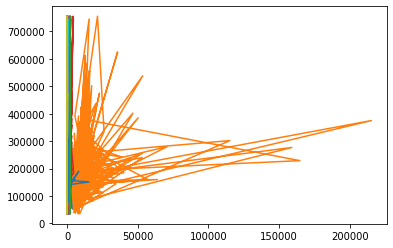

In [14]:
import matplotlib.pyplot as plt
predicted=model.predict(one_hot_encoded_test)
plt.plot(one_hot_encoded_test,target)
plt.show()

In [15]:
submission=pd.DataFrame({"ID":test_df.Id,"Predicted":predicted,"Actual":target})
submission.head()

,ID,Predicted,Actual
0,1,204910.833333,208500
1,2,176033.333333,181500
2,3,221496.250000,223500
3,4,152927.666667,140000
4,5,266340.000000,250000


In [16]:
submission.to_csv('submission.csv', index=False)